In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import psutil

# Get the virtual memory details
virtual_memory = psutil.virtual_memory()

# Print the total, available, and used memory
print(f"Total memory: {virtual_memory.total / 1e9} GB")
print(f"Available memory: {virtual_memory.available / 1e9} GB")
print(f"Used memory: {virtual_memory.used / 1e9} GB")

Total memory: 67.43003136 GB
Available memory: 61.250174976 GB
Used memory: 5.434277888 GB


autograd calc

In [2]:
import torch
import scipy.io as sio
from hamiltonians.Central import KitaevChain
from hamiltonians.Lead import SpinlessLead
from genfunc_cf_deriv_method.workflow.construct_ginv_total import construct_ginv_total
from genfunc_cf_deriv_method.calculations.calculation_cf_autograd import calculation_cf_autograd
from greens_functions_inv_method.transport_calculation import calculate_transport_properties
funcDevice='cuda'
# Define parameters for the central region
Nx = 4  # Number of sites in the Kitaev chain
t = torch.tensor(6, dtype=torch.complex64, device=funcDevice)  # Hopping parameter
mu = torch.tensor(6, dtype=torch.complex64, device=funcDevice)  # Chemical potential
Delta = torch.tensor(6, dtype=torch.complex64, device=funcDevice)  # Superconducting pairing

# Create Kitaev chain Hamiltonian
KitaevChain8 = KitaevChain(Nx=Nx, t=t, mu=mu, Delta=Delta)

H_BdG=KitaevChain8.H_full
from greens_functions_inv_method.transport_calculation import calculate_transport_properties

Eigenvalues = torch.linalg.eigvals(H_BdG).real.sort()[0]
print(Eigenvalues)

tensor([-16.9610, -13.9935,  -9.6012,  -0.5687,   0.5687,   9.6012,  13.9935,
         16.9610], device='cuda:0')


In [3]:
# Calculate eigenvalues of the SSH chain Hamiltonian
eigenvalues = torch.linalg.eigvals(H_BdG).real

# Sort eigenvalues for better visualization
sorted_eigenvalues = eigenvalues.sort()[0]

# Print the sorted eigenvalues
print("Sorted eigenvalues of the kitaev chain Hamiltonian:")
print(sorted_eigenvalues)


Sorted eigenvalues of the kitaev chain Hamiltonian:
tensor([-16.9610, -13.9935,  -9.6012,  -0.5687,   0.5687,   9.6012,  13.9935,
         16.9610], device='cuda:0')


In [5]:
# Define parameters for the leads as torch tensors
mu_values = torch.tensor([-20.0, 20.0], dtype=torch.float32, device=funcDevice)  # Chemical potentials for each lead
t_lead_central = torch.tensor(1, dtype=torch.float32, device=funcDevice)  # Coupling strength between lead and central region
t_lead = torch.tensor(20.0, dtype=torch.float32, device=funcDevice)  # Hopping parameter within the lead
temperature = torch.tensor(1e-6, dtype=torch.float32, device=funcDevice)  # Temperature

# Create connection coordinates for left and right leads
left_connection = [(0, 0)]  # Left lead connects to the first site
right_connection = [(Nx-1, 0)]  # Right lead connects to the last site

# Create lead objects
leads_info = [
    SpinlessLead(mu=mu_values[0], 
                t_lead=t_lead, 
                connection_coordinates=left_connection,
                central_Nx=Nx,
                central_Ny=1,
                device=funcDevice,
                temperature=temperature,
                t_lead_central=t_lead_central),
    
    SpinlessLead(mu=mu_values[1], 
                t_lead=t_lead, 
                connection_coordinates=right_connection,
                central_Nx=Nx,
                central_Ny=1,
                device=funcDevice,
                temperature=temperature,
                t_lead_central=t_lead_central)
]

# Define energy and small imaginary part for regularization
# Calculate eigenvalues of H_BdG
eigenvalues = torch.linalg.eigvals(H_BdG).real.sort()[0]  # Sort eigenvalues


In [6]:

# Create base energy grid
E_min, E_max = -1, 1
num_points = 1000
base_E = torch.linspace(E_min, E_max, steps=num_points, dtype=torch.float32, device=funcDevice)
E = base_E
eta = torch.tensor(1e-4, dtype=torch.float32, device=funcDevice)

# Create directory to save results with parameter information
import os
import time
from datetime import datetime

params_str = f"Nx{Nx}_tc{t:.1f}_Delta{Delta:.1f}_muc{mu:.1f}_tlc{t_lead_central:.1f}_E{E_min:.2f}_{E_max:.2f}_pts{num_points}"
results_dir = os.path.join("data", "kitaev_chain", "compareGenwithDirect", f"results_{datetime.now().strftime('%Y%m%d_%H%M')}_{params_str}")
os.makedirs(results_dir, exist_ok=True)

# Method 1: Using autograd general function method
chunk_size = 10
results_list_autograd = []

start_time_autograd = time.time()
for start in range(0, E.size(0), chunk_size):
    end = min(start + chunk_size, E.size(0))
    chunked_E = E[start:end]
    print(f"Processing chunk {start} to {end}")
    results = calculation_cf_autograd(H_BdG, chunked_E, eta, leads_info, max_derivative_order=2)
    results_list_autograd.append(results)
autograd_time = time.time() - start_time_autograd

# Combine results from all chunks for autograd method
combined_results_autograd = {
    'gen_func_values_real': torch.cat([res['gen_func_values_real'] for res in results_list_autograd], dim=0),
    'gen_func_values_imag': torch.cat([res['gen_func_values_imag'] for res in results_list_autograd], dim=0),
    'derivatives': {}
}

# Combine derivatives
for order in results_list_autograd[0]['derivatives'].keys():
    combined_results_autograd['derivatives'][order] = torch.cat([res['derivatives'][order] for res in results_list_autograd], dim=0)

# Method 2: Using direct calculation method


results_list_direct = []
start_time_direct = time.time()
for start in range(0, E.size(0), chunk_size):
    end = min(start + chunk_size, E.size(0))
    chunked_E = E[start:end]
    print(f"Processing chunk {start} to {end}")
    results = calculate_transport_properties(
        E_batch=chunked_E,
        H_total=H_BdG,
        leads_info=leads_info,
        temperature=temperature,
        eta=eta
    )
    results_list_direct.append(results)
direct_time = time.time() - start_time_direct

# Combine results from all chunks for direct calculation method
combined_results_direct = {}
for key in results_list_direct[0].keys():
    if isinstance(results_list_direct[0][key], torch.Tensor):
        combined_results_direct[key] = torch.cat([res[key] for res in results_list_direct], dim=0).cpu().numpy()
    else:
        combined_results_direct[key] = results_list_direct[0][key]

# Save timing information
timing_info = {
    'autograd_time': autograd_time,
    'direct_time': direct_time,
    'speedup_factor': autograd_time / direct_time if direct_time > 0 else float('inf')
}

# Save all results
combined_results_autograd['timing'] = timing_info
combined_results_direct['timing'] = timing_info

# Save results to files
autograd_filename = os.path.join(results_dir, f'autograd_results.mat')
direct_filename = os.path.join(results_dir, f'direct_results.mat')
timing_filename = os.path.join(results_dir, f'timing_comparison.mat')

sio.savemat(autograd_filename, combined_results_autograd)
sio.savemat(direct_filename, combined_results_direct)
sio.savemat(timing_filename, timing_info)

# Print timing comparison
print(f"\nPerformance Comparison:")
print(f"Autograd Generating Function Method: {autograd_time:.4f} seconds")
print(f"Direct Calculation Method: {direct_time:.4f} seconds")
print(f"Speedup: {timing_info['speedup_factor']:.2f}x")
print(f"\nResults saved in: {results_dir}")


Processing chunk 0 to 10
Processing chunk 10 to 20
Processing chunk 20 to 30
Processing chunk 30 to 40
Processing chunk 40 to 50
Processing chunk 50 to 60
Processing chunk 60 to 70
Processing chunk 70 to 80
Processing chunk 80 to 90
Processing chunk 90 to 100
Processing chunk 100 to 110
Processing chunk 110 to 120
Processing chunk 120 to 130
Processing chunk 130 to 140
Processing chunk 140 to 150
Processing chunk 150 to 160
Processing chunk 160 to 170
Processing chunk 170 to 180
Processing chunk 180 to 190
Processing chunk 190 to 200
Processing chunk 200 to 210
Processing chunk 210 to 220
Processing chunk 220 to 230
Processing chunk 230 to 240
Processing chunk 240 to 250
Processing chunk 250 to 260
Processing chunk 260 to 270
Processing chunk 270 to 280
Processing chunk 280 to 290
Processing chunk 290 to 300
Processing chunk 300 to 310
Processing chunk 310 to 320
Processing chunk 320 to 330
Processing chunk 330 to 340
Processing chunk 340 to 350
Processing chunk 350 to 360
Processing c

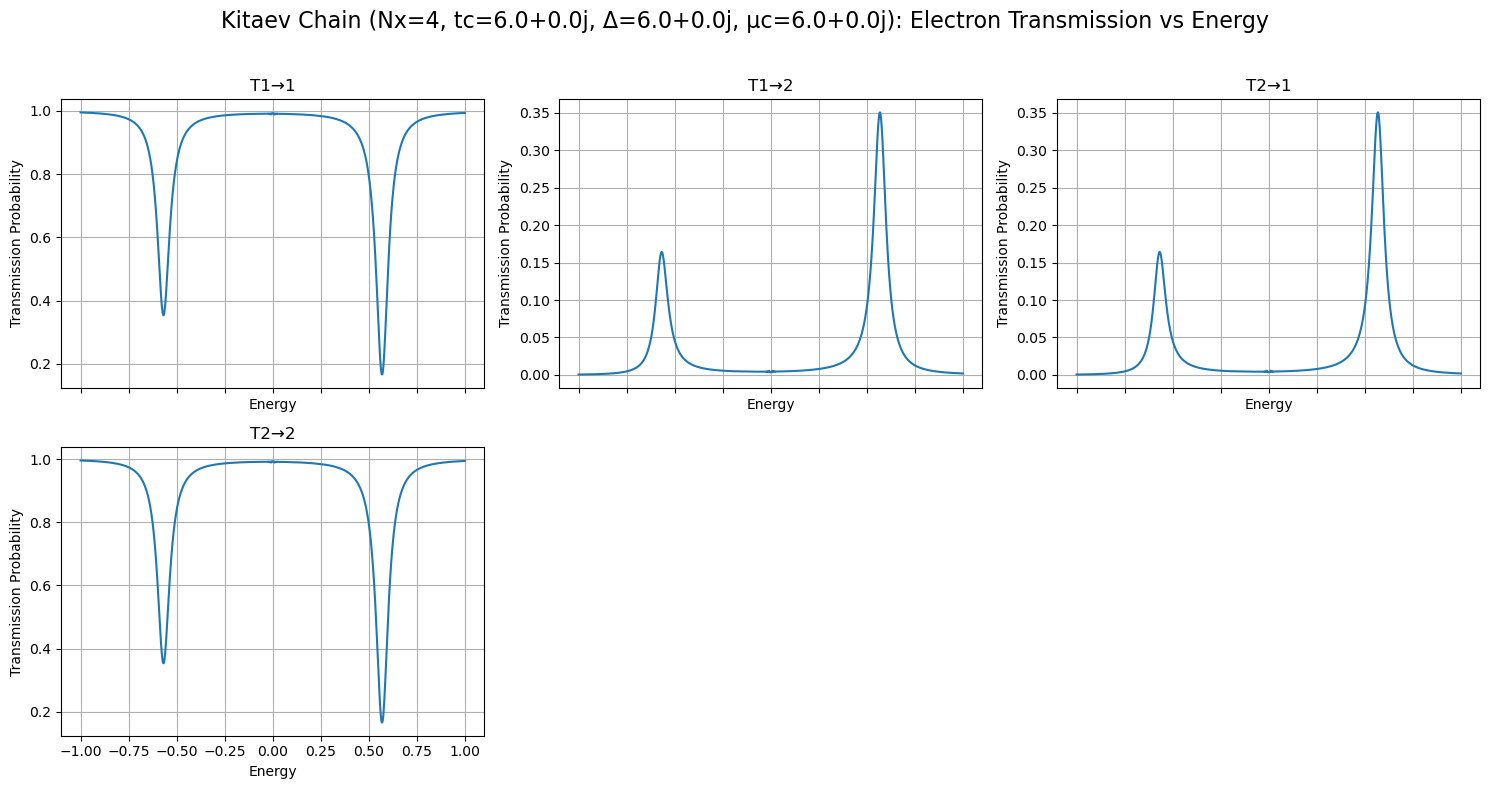

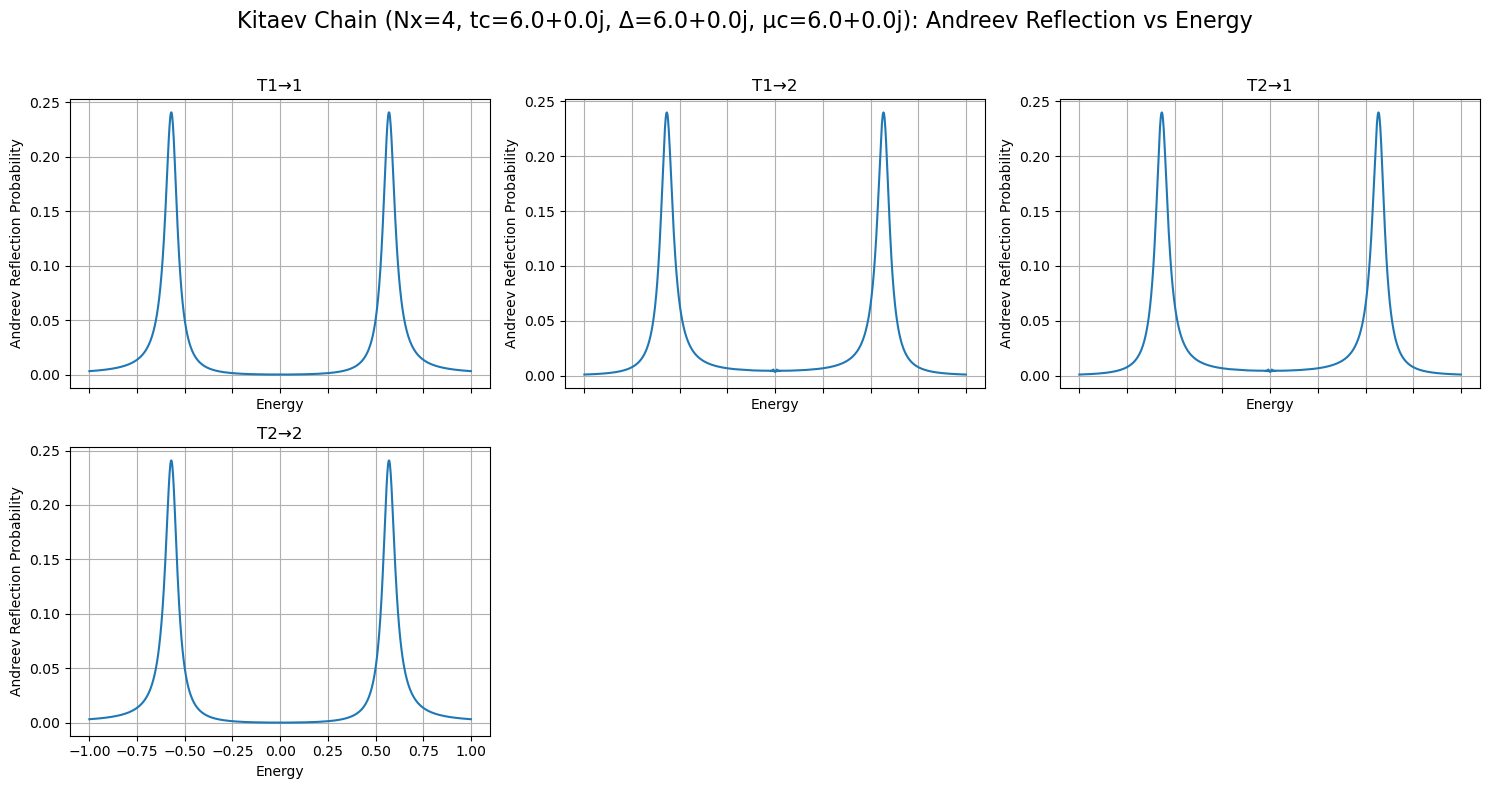

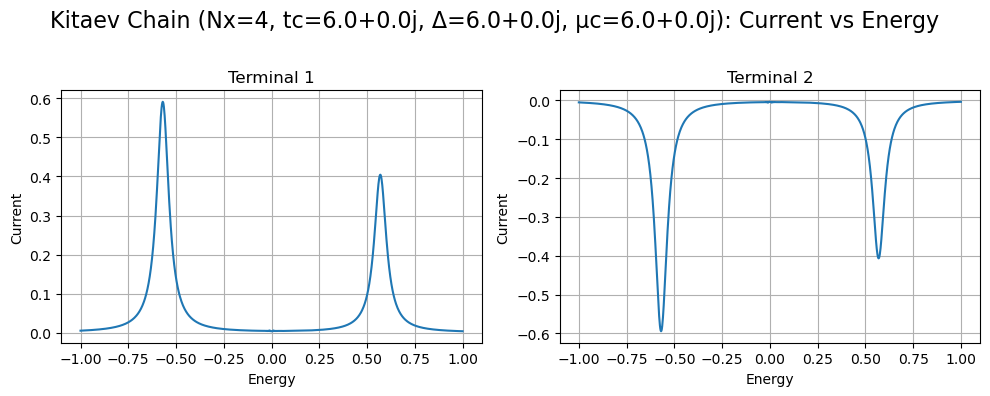

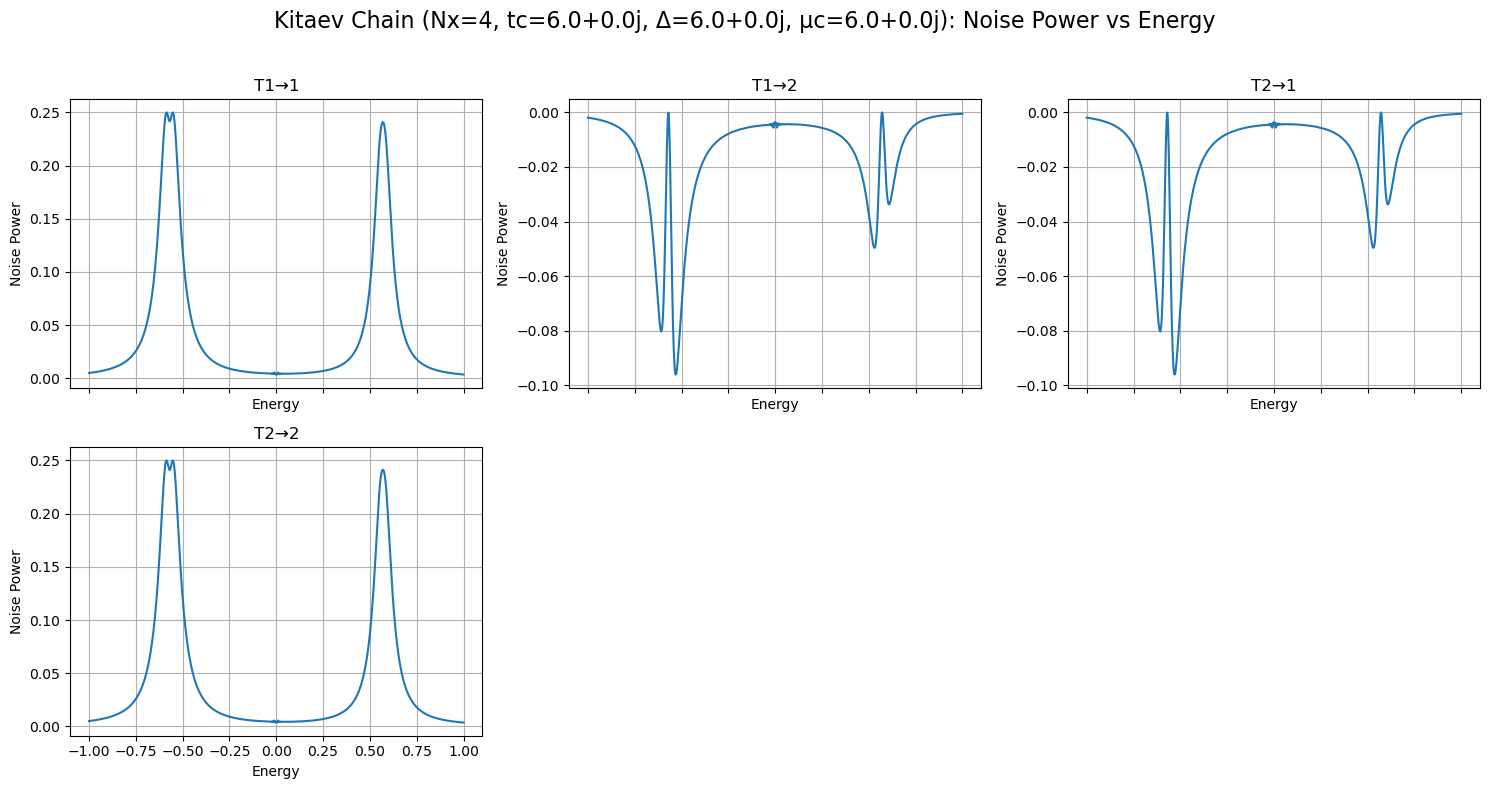


Performance Comparison:
Autograd Generating Function Method: 38.1450 seconds
Direct Calculation Method: 12.7964 seconds
Speedup: 2.98x

Results saved in: data/kitaev_chain/compareGenwithDirect/results_20250729_1953_Nx4_tc6.0+0.0j_Delta6.0+0.0j_muc6.0+0.0j_tlc1.0_E-1.00_1.00_pts1000


In [7]:


# Plot all transport quantities from direct calculation method
from dataplot.transport_plot import plot_all_transport_quantities

# Convert E back to numpy for plotting
E_numpy = E.cpu().numpy()

# Create transport data dictionary with the expected keys
transport_data = {
    'transmission': combined_results_direct['transmission'],
    'andreev': combined_results_direct['andreev'], 
    'current': combined_results_direct['current'],
    'noise': combined_results_direct['noise']
}

# Plot all transport quantities
plot_all_transport_quantities(
    E_values=E_numpy,
    transport_data=transport_data,
    save_dir=results_dir,
    title_prefix=f"Kitaev Chain (Nx={Nx}, tc={t:.1f}, Δ={Delta:.1f}, μc={mu:.1f}): "
)

# Print timing comparison
print(f"\nPerformance Comparison:")
print(f"Autograd Generating Function Method: {autograd_time:.4f} seconds")
print(f"Direct Calculation Method: {direct_time:.4f} seconds")
print(f"Speedup: {timing_info['speedup_factor']:.2f}x")
print(f"\nResults saved in: {results_dir}")

Available autograd derivative keys: ['order_1', 'order_2']
Available direct result keys: ['rho_e_jj', 'rho_electron', 'rho_hole', 'transmission', 'andreev', 'current', 'noise', 'current_density', 'timing']


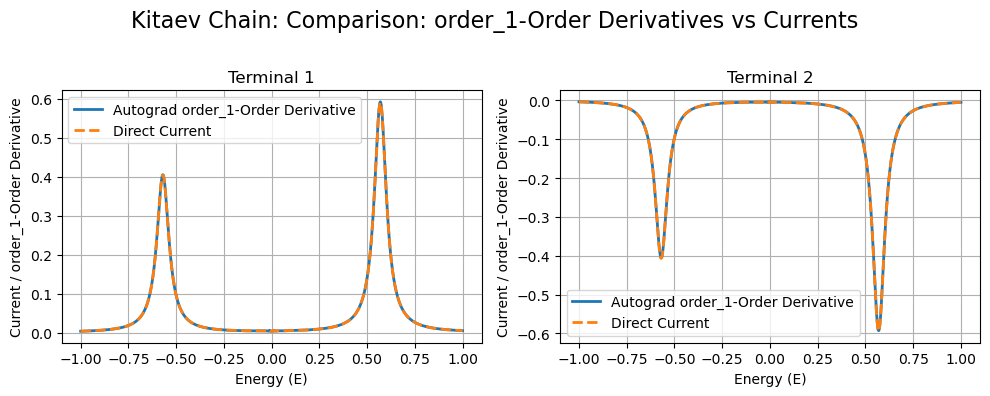

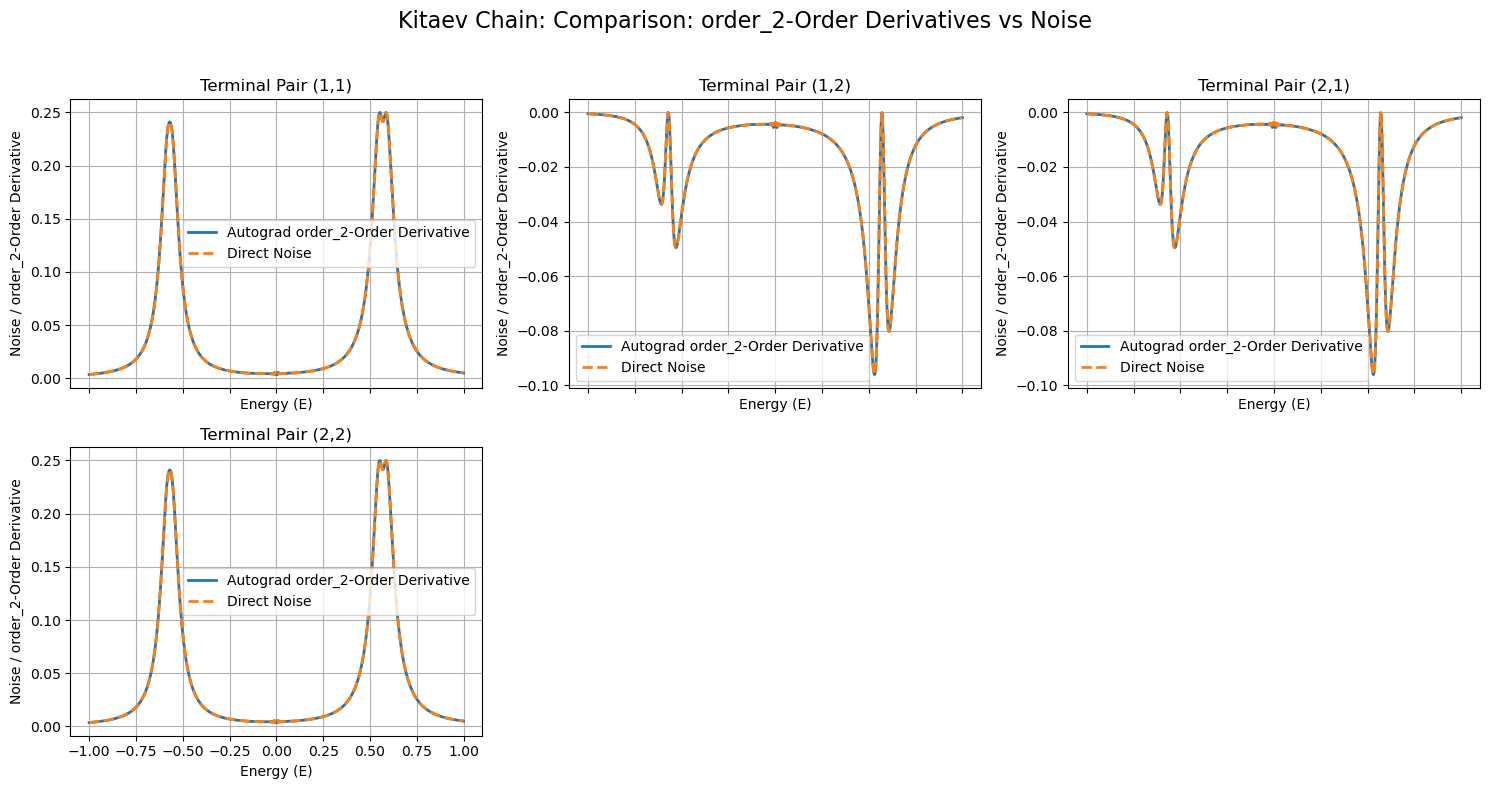

In [19]:
# After running your calculations
from dataplot.transport_plot import plot_comprehensive_comparison

# Create comparison plots
plot_comprehensive_comparison(
    E_values=E,  # Your energy grid
    autograd_results=combined_results_autograd,
    direct_results=combined_results_direct,
    save_dir=os.path.join(results_dir, "comparison_plots"),
    title_prefix="Kitaev Chain: "
)

# Calc higher order correlations using autograd

In [45]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

def plot_comparison_from_files_vary_tLeadCentral(data_dir="./data/ssh_chain", plot_type="all"):
    """
    Reads all data files and plots them using a similar approach to the original plot_all function.
    
    Args:
        data_dir: Directory containing the data files
        plot_type: "all", "genfunc", "derivatives"
    """
    # Find all .mat files in the directory
    file_pattern = os.path.join(data_dir, "ssh_Nx8_tu-1.0+0.0j_tv-0.5+0.0j_mu-1.0+0.0j_Delta0.0+0.0j_split_onsite0.0_tlc*_temp1.0e-06.mat")
    file_paths = glob.glob(file_pattern)
    
    if not file_paths:
        print(f"No files found matching pattern {file_pattern}")
        return
    
    # Sort files by t_lead_central value
    file_paths.sort(key=lambda f: float(f.split('_tlc')[1].split('_')[0]))
    
    # Create a colormap for different files
    colors = plt.cm.tab10(np.linspace(0, 1, len(file_paths)))
    
    # Plot generating function if requested
    if plot_type in ["all", "genfunc"]:
        plt.figure(figsize=(12, 8))
        for i, file_path in enumerate(file_paths):
            data = sio.loadmat(file_path)
            t_lc = float(file_path.split('_tlc')[1].split('_')[0])
            E = data['E'].flatten()
            
            real_values = data['gen_func_values_real'].flatten()
            imag_values = data['gen_func_values_imag'].flatten()
            
            plt.plot(E, real_values, color=colors[i], label=f"t_lc={t_lc:.1f} (Real)")
            plt.plot(E, imag_values, '--', color=colors[i], label=f"t_lc={t_lc:.1f} (Imag)")
        
        plt.xlabel('Energy (E)')
        plt.ylabel('Generating Function')
        plt.title('Generating Function vs Energy for Different Lead Couplings')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(data_dir, "comparison_genfunc.png"), dpi=300)
        plt.show()
    
    # Plot derivatives if requested
    if plot_type in ["all", "derivatives"]:
        # Load the first file to determine which derivative orders are available
        first_file = sio.loadmat(file_paths[0])
        derivatives = first_file['derivatives']
        
        # Get the derivative field names (order_1, order_2, etc.)
        field_names = derivatives.dtype.names
        
        # Process each order of derivatives
        for field in field_names:
            order = field.split('_')[1]  # Extract the order number
            
            plt.figure(figsize=(12, 8))
            for i, file_path in enumerate(file_paths):
                data = sio.loadmat(file_path)
                t_lc = float(file_path.split('_tlc')[1].split('_')[0])
                E = data['E'].flatten()
                
                # Get the derivative data for this order
                deriv_data = data['derivatives'][field][0, 0]
                
                # Plot based on the dimensionality of the derivative data
                # Following the same approach as the original plot_all function
                if deriv_data.ndim == 2:
                    # First-order derivatives
                    for lead_idx in range(deriv_data.shape[1]):
                        plt.plot(E, deriv_data[:, lead_idx], 
                                color=colors[i],
                                linestyle='-' if lead_idx == 0 else '--',
                                label=f"t_lc={t_lc:.1f} Lead {lead_idx + 1}")
                
                elif deriv_data.ndim == 3:
                    # Second-order derivatives (Hessian)
                    # Limit to specific combinations to avoid overcrowding
                    key_indices = [(0,0), (0,1)]
                    styles = ['-', '--', '-.']
                    
                    for idx, (i_idx, j_idx) in enumerate(key_indices):
                        if i_idx < deriv_data.shape[1] and j_idx < deriv_data.shape[2]:
                            plt.plot(E, deriv_data[:, i_idx, j_idx], 
                                    color=colors[i],
                                    linestyle=styles[idx],
                                    label=f"t_lc={t_lc:.1f} [{i_idx+1},{j_idx+1}]")
                
                elif deriv_data.ndim == 4:
                    # Third-order derivatives - just plot a few key combinations
                    plt.plot(E, deriv_data[:, 0, 0, 0], color=colors[i],
                            label=f"t_lc={t_lc:.1f} [1,1,1]")
                    
                    if deriv_data.shape[1] > 1 and deriv_data.shape[2] > 1 and deriv_data.shape[3] > 1:
                        plt.plot(E, deriv_data[:, 1, 1, 1], '--', color=colors[i],
                                label=f"t_lc={t_lc:.1f} [2,2,2]")
                
                elif deriv_data.ndim == 5:
                    # Fourth-order derivatives - plot key diagonal elements
                    plt.plot(E, deriv_data[:, 0, 0, 0, 0], color=colors[i],
                            label=f"t_lc={t_lc:.1f} [1,1,1,1]")
                    
                    if deriv_data.shape[1] > 1 and deriv_data.shape[2] > 1 and deriv_data.shape[3] > 1 and deriv_data.shape[4] > 1:
                        plt.plot(E, deriv_data[:, 0, 1, 1, 1], '--', color=colors[i],
                                label=f"t_lc={t_lc:.1f} [1,2,2,2]")
            plt.xlabel('Energy (E)')
            plt.ylabel(f'Order {order} Derivative')
            plt.title(f'Order {order} Derivatives vs Energy for Different Lead Couplings')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.savefig(os.path.join(data_dir, f"comparison_derivative_order{order}.png"), dpi=300)
            plt.show()


In [4]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

def plot_comparison_from_files_vary_onsite_split(data_dir="./data/ssh_chain", plot_type="all"):
    """
    Reads all data files and plots them while varying the onsite split parameter.
    
    Args:
        data_dir: Directory containing the data files
        plot_type: "all", "genfunc", "derivatives"
    """
    # Find all .mat files in the directory
    file_pattern = os.path.join(data_dir, "ssh_Nx8_tu-1.00+0.00j_tv-0.50+0.00j_mu-1.00+0.00j_Delta0.00+0.00j_split_onsite*_tlc1.00_temp1.0e-06.mat")
    file_paths = glob.glob(file_pattern)
    
    if not file_paths:
        print(f"No files found matching pattern {file_pattern}")
        return
    
    # Sort files by onsite split value
    file_paths.sort(key=lambda f: float(f.split('_onsite')[1].split('_')[0]))
    
    # Create a colormap for different files
    colors = plt.cm.tab10(np.linspace(0, 1, len(file_paths)))
    
    # Plot generating function if requested
    if plot_type in ["all", "genfunc"]:
        plt.figure(figsize=(12, 8))
        for i, file_path in enumerate(file_paths):
            data = sio.loadmat(file_path)
            onsite_split = float(file_path.split('_onsite')[1].split('_')[0])
            E = data['E'].flatten()
            
            real_values = data['gen_func_values_real'].flatten()
            imag_values = data['gen_func_values_imag'].flatten()
            
            plt.plot(E, real_values, color=colors[i], label=f"onsite={onsite_split:.1f} (Real)")
            plt.plot(E, imag_values, '--', color=colors[i], label=f"onsite={onsite_split:.1f} (Imag)")
        
        plt.xlabel('Energy (E)')
        plt.ylabel('Generating Function')
        plt.title('Generating Function vs Energy for Different Onsite Splits')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(data_dir, "comparison_genfunc_onsite.png"), dpi=300)
        plt.show()
    
    # Plot derivatives if requested
    if plot_type in ["all", "derivatives"]:
        # Load the first file to determine which derivative orders are available
        first_file = sio.loadmat(file_paths[0])
        derivatives = first_file['derivatives']
        
        # Get the derivative field names (order_1, order_2, etc.)
        field_names = derivatives.dtype.names
        
        # Process each order of derivatives
        for field in field_names:
            order = field.split('_')[1]  # Extract the order number
            
            plt.figure(figsize=(12, 8))
            for i, file_path in enumerate(file_paths):
                data = sio.loadmat(file_path)
                onsite_split = float(file_path.split('_onsite')[1].split('_')[0])
                E = data['E'].flatten()
                
                # Get the derivative data for this order
                deriv_data = data['derivatives'][field][0, 0]
                
                # Plot based on the dimensionality of the derivative data
                if deriv_data.ndim == 2:
                    # First-order derivatives
                    for lead_idx in range(deriv_data.shape[1]):
                        plt.plot(E, deriv_data[:, lead_idx], 
                                color=colors[i],
                                linestyle='-' if lead_idx == 0 else '--',
                                label=f"onsite={onsite_split:.2f} Lead {lead_idx + 1}")
                
                elif deriv_data.ndim == 3:
                    # Second-order derivatives (Hessian)
                    key_indices = [(0,0), (0,1)]
                    styles = ['-', '--', '-.']
                    
                    for idx, (i_idx, j_idx) in enumerate(key_indices):
                        if i_idx < deriv_data.shape[1] and j_idx < deriv_data.shape[2]:
                            plt.plot(E, deriv_data[:, i_idx, j_idx], 
                                    color=colors[i],
                                    linestyle=styles[idx],
                                    label=f"onsite={onsite_split:.2f} [{i_idx+1},{j_idx+1}]")
                
                elif deriv_data.ndim == 4:
                    # Third-order derivatives
                    plt.plot(E, deriv_data[:, 0, 0, 0], color=colors[i],
                            label=f"onsite={onsite_split:.2f} [1,1,1]")
                    
                    if deriv_data.shape[1] > 1 and deriv_data.shape[2] > 1 and deriv_data.shape[3] > 1:
                        plt.plot(E, deriv_data[:, 1, 1, 1], '--', color=colors[i],
                                label=f"onsite={onsite_split:.2f} [2,2,2]")
                
                elif deriv_data.ndim == 5:
                    # Fourth-order derivatives
                    plt.plot(E, deriv_data[:, 0, 0, 0, 0], color=colors[i],
                            label=f"onsite={onsite_split:.2f} [1,1,1,1]")
                    
                    if deriv_data.shape[1] > 1 and deriv_data.shape[2] > 1 and deriv_data.shape[3] > 1 and deriv_data.shape[4] > 1:
                        plt.plot(E, deriv_data[:, 0, 1, 1, 1], '--', color=colors[i],
                                label=f"onsite={onsite_split:.2f} [1,2,2,2]")
            plt.xlabel('Energy (E)')
            plt.ylabel(f'Order {order} Derivative')
            plt.title(f'Order {order} Derivatives vs Energy for Different Onsite Splits')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.savefig(os.path.join(data_dir, f"comparison_derivative_order{order}_onsite.png"), dpi=300)
            plt.show()


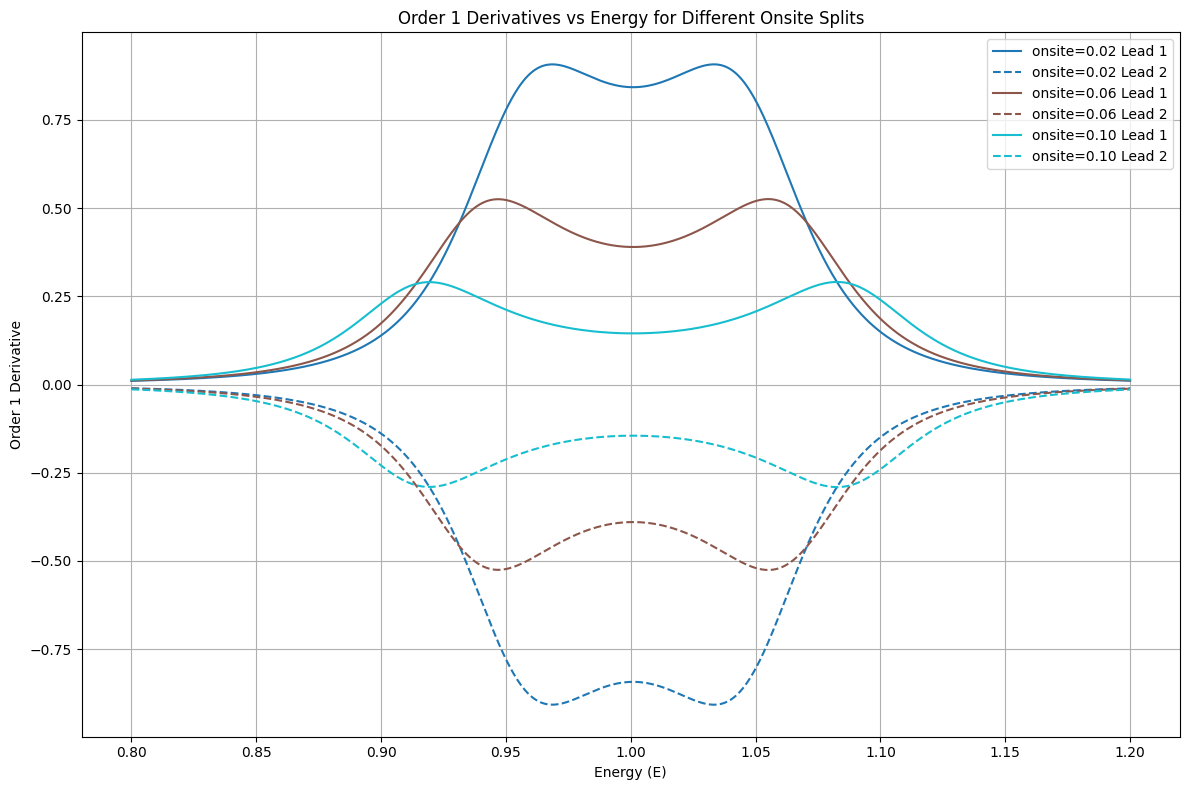

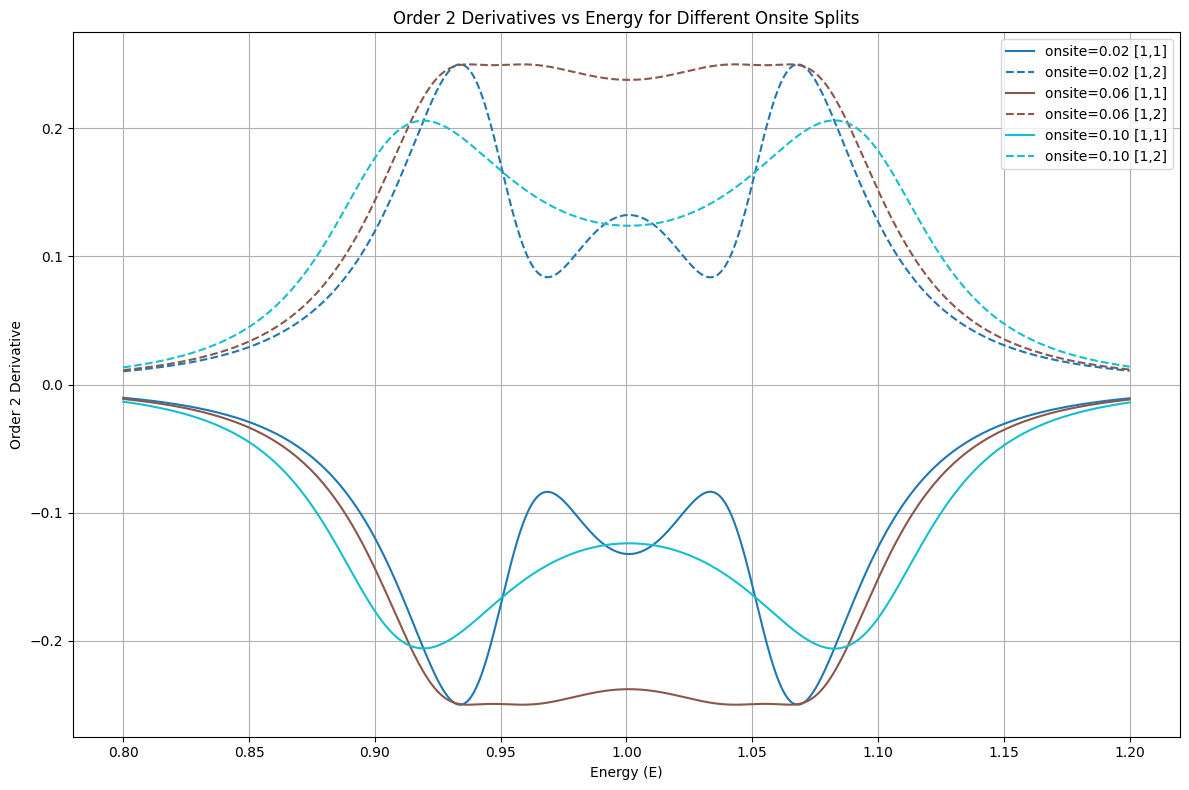

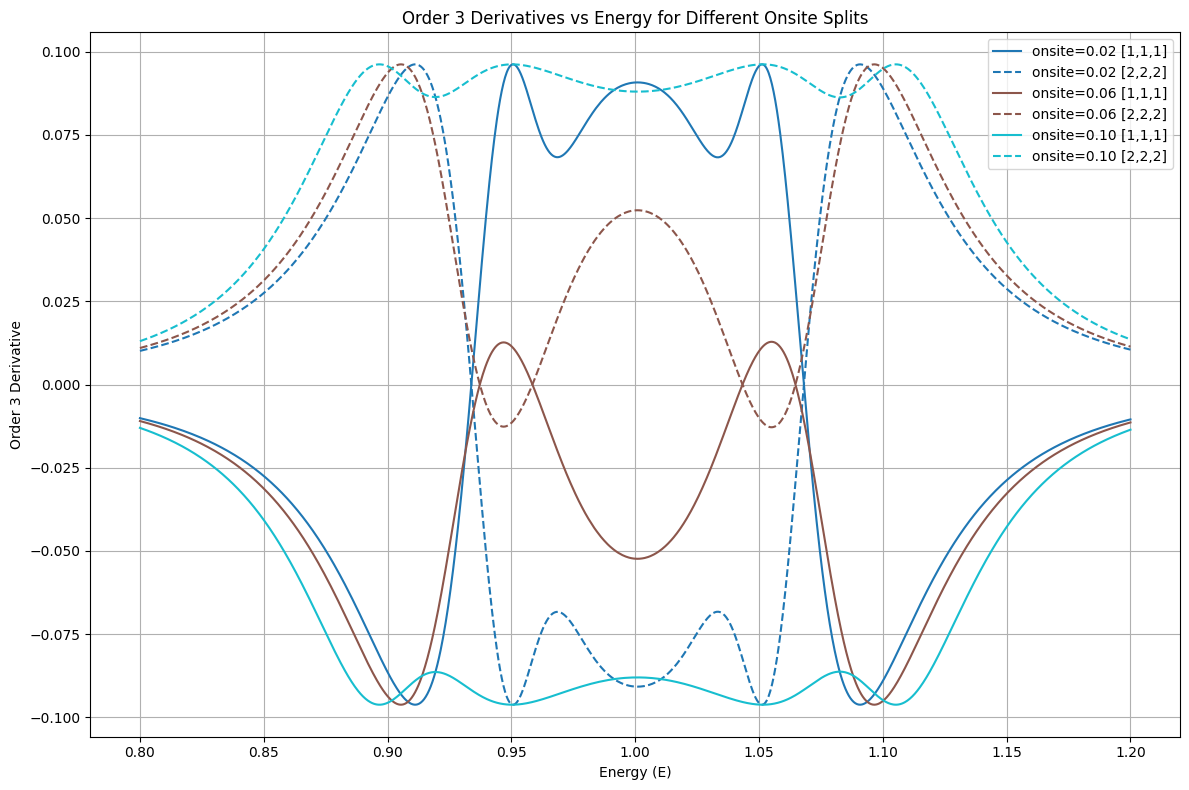

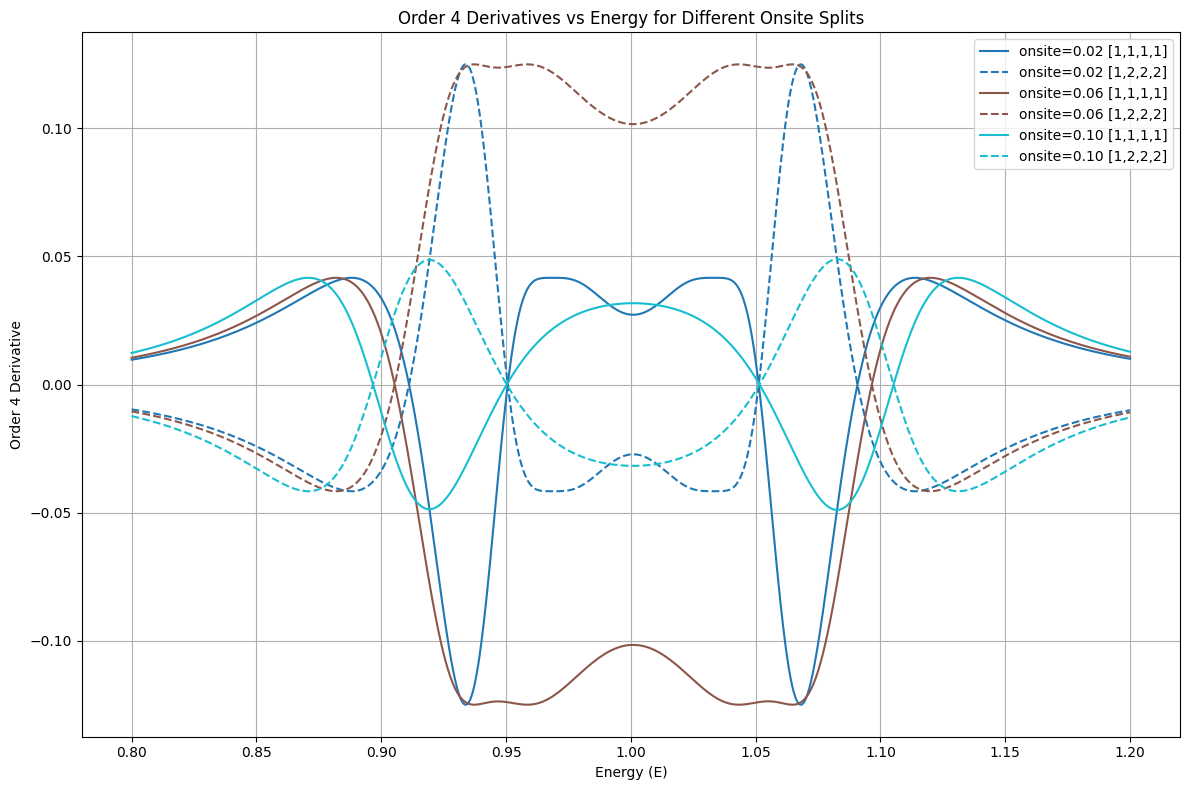

In [5]:

# Usage example:
# plot_comparison_from_files(plot_type="all")  # Generate all plots
# plot_comparison_from_files(plot_type="genfunc")  # Only generating function
plot_comparison_from_files_vary_onsite_split(plot_type="derivatives")  # Only derivatives